## Advance pipeline
In the section we will be creating a more advanced pipeline using this `python-sdk` to utilize the power of `Instill VDP`!

Before we get into this, please make sure a local instance of `Instill VDP` and `Instill Model` is running,  and the config file had  been populated with the correct `url` and `api_token`

Let's get started!

### Import packages

In [1]:
import base64
import requests

from google.protobuf.struct_pb2 import Struct
from instill.clients import get_client
from instill.resources.model import GithubModel

from instill.resources import (
    InstillModelConnector,
    OpenAIConnector,
    StabilityAIConnector,
    Pipeline,
    create_start_operator,
    create_end_operator,
    create_recipe,
)

### Get the client

Get the unified client that cconnect to all the available services offer by `Instill VDP` and `Instill Model`, including
- mgmt_service
- pipeline_service
- connector_service
- model_service

In [2]:
client = get_client()
# check the connection to all services
client.mgmt_service.is_serving()
# True
client.connector_service.is_serving()
# True
client.pipeline_service.is_serving()
# True
client.model_service.is_serving()
# True

user = client.mgmt_service.get_user()
# name: "users/admin"
# uid: "4767b74d-640a-4cdf-9c6d-7bb0e36098a0"
# id: "admin"
# type: OWNER_TYPE_USER
# create_time {
#   seconds: 1695589596
#   nanos: 36522000
# }
# update_time {
#   seconds: 1695589749
#   nanos: 544980000
# }
# email: "hello@instill.tech"
# first_name: "Instill"
# last_name: "AI"
# org_name: "Instill AI"
# role: "hobbyist"
# newsletter_subscription: true
# cookie_token: ""

### Create a classification model

Now create a classification model `mobilenetv2` in our handy `Instill Model` service for later use

In [3]:
mobilenetv2_config = {
    "model_name": "mobilenetv2",
    "model_repo": "instill-ai/model-mobilenetv2-dvc",
    "model_tag": "v1.0-cpu",
}
# create model
mobilenet = GithubModel(
    client=client,
    name=mobilenetv2_config["model_name"],
    model_repo=mobilenetv2_config["model_repo"],
    model_tag=mobilenetv2_config["model_tag"],
)
# after creation, model is offline
# deploy model
mobilenet.deploy()

name: "users/admin/models/mobilenetv2"
uid: "8aed4fe5-d7ae-4168-acf2-c54793a221b2"
id: "mobilenetv2"
description: ""
model_definition: "model-definitions/github"
configuration {
  fields {
    key: "tag"
    value {
      string_value: "v1.0-cpu"
    }
  }
  fields {
    key: "repository"
    value {
      string_value: "instill-ai/model-mobilenetv2-dvc"
    }
  }
  fields {
    key: "html_url"
    value {
      string_value: "https://github.com/instill-ai/model-mobilenetv2-dvc"
    }
  }
}
task: TASK_CLASSIFICATION
state: STATE_ONLINE
visibility: VISIBILITY_PUBLIC
user: "users/4767b74d-640a-4cdf-9c6d-7bb0e36098a0"
create_time {
  seconds: 1696089958
  nanos: 974411000
}
update_time {
  seconds: 1696089963
  nanos: 92733000
}

### Create connectors to various vendors
In order to form a pipeline, we first need to config a list of connector resources which will allow us to connect the pipeline to other third party services like OpenAI and Stability AI

In [4]:
# connector resource for Instill Model
instill_connector = InstillModelConnector(
    client,
    name="instill",
    server_url="http://api-gateway:8080",
)
# connector resource for OpenAI
openai_connector = OpenAIConnector(
    client,
    name="openai",
    api_key="",  # remember to supply your own openai api_key here
)
# connector resource for Stability AI
stability_connector = StabilityAIConnector(
    client,
    name="stabilityai",
    api_key="",  # remember to supply your own openai api_key here
)

### Create a pipeline

Now we are ready to construct a pipeline!

Let us create some components.

NOTE: `start operator` and `end operator` are the necessary components for a pipeline recipe.

In [5]:
# define your desired input, here we wish to input a list of base64 images
start_operator_component = create_start_operator(
    {"metadata": {"input": {"title": "input", "type": "array", "instillFormat": "array:image/*", "items": {"type": "string"}}}}
)

# create a instill model component from the connector resource
# need to specify the target model namepsace and id you want to connect to in the config
instill_model_component_mobilenet_1 = instill_connector.create_component(
    name="m1",
    config={
        "input": {
            "image_base64": "{ start.input[0] }",
            "model_namespace": "admin",
            "model_id": "mobilenetv2",
        },
        "task": "TASK_CLASSIFICATION",
    },
)

instill_model_component_mobilenet_2 = instill_connector.create_component(
    name="m2",
    config={
        "input": {
            "image_base64": "{ start.input[1] }",
            "model_namespace": "admin",
            "model_id": "mobilenetv2",
        },
        "task": "TASK_CLASSIFICATION",
    },
)

# create a openai component and fill in the required config
openai_component = openai_connector.create_component(
    name="gpt",
    config={
        "input": {
            "prompt": "write a upbeat story about friendship between {{ m1.output.category }} and {{ m2.output.category }}",
            "model": "gpt-3.5-turbo",
            "system_message": "You are a skillful storywriter for childbook",
            "temperature": 0.7,
            "n": 1,
            "max_tokens": 256,
        },
        "task": "TASK_TEXT_GENERATION",
    },
)

# create a stabilityai component and fill in the required config
stability_ai_component = stability_connector.create_component(
    name="sd",
    config={
        "input": {
            "engine": "stable-diffusion-xl-1024-v1-0",
            "prompts": "{ gpt.output.texts }",
            "style_preset": "comic-book",
            "width": 896,
            "height": 1152,
        },
        "task": "TASK_TEXT_TO_IMAGE",
    },
)

# define the desired output
end_operator_component = create_end_operator(
    config={
        "input": {"output": "{{ sd.output.images }}"},
        "metadata": {"output": {"title": "output"}},
    }
)

# create recipe from the above components
recipe = create_recipe(
    [
        start_operator_component,
        instill_model_component_mobilenet_1,
        instill_model_component_mobilenet_2,
        openai_component,
        stability_ai_component,
        end_operator_component,
    ]
)

# finally we create the pipeline from the recipe and give it a name
cute_pipeline = Pipeline(client=client, name="cute-pipeline", recipe=recipe)

### Validate the pipeline

Before we trigger the pipeline, it is recommended to first validate the recipe first

In [6]:
# validate the pipeline recipe
cute_pipeline.validate_pipeline();

### Trigger the pipeline

Now it is time to trigger this awesome pipeline!

In [7]:
# create a list of input images
i = Struct()
i.update(
    {
        "input": [
            base64.b64encode(
                requests.get(
                    "https://artifacts.instill.tech/imgs/dog.jpg",
                    timeout=5,
                ).content
            ).decode("ascii"),
            base64.b64encode(
                requests.get(
                    "https://artifacts.instill.tech/imgs/polar-bear.jpg",
                    timeout=5,
                ).content
            ).decode("ascii"),
        ]
    }
)

# trigger the pipeline
output = cute_pipeline([i])[0][0]["output"]

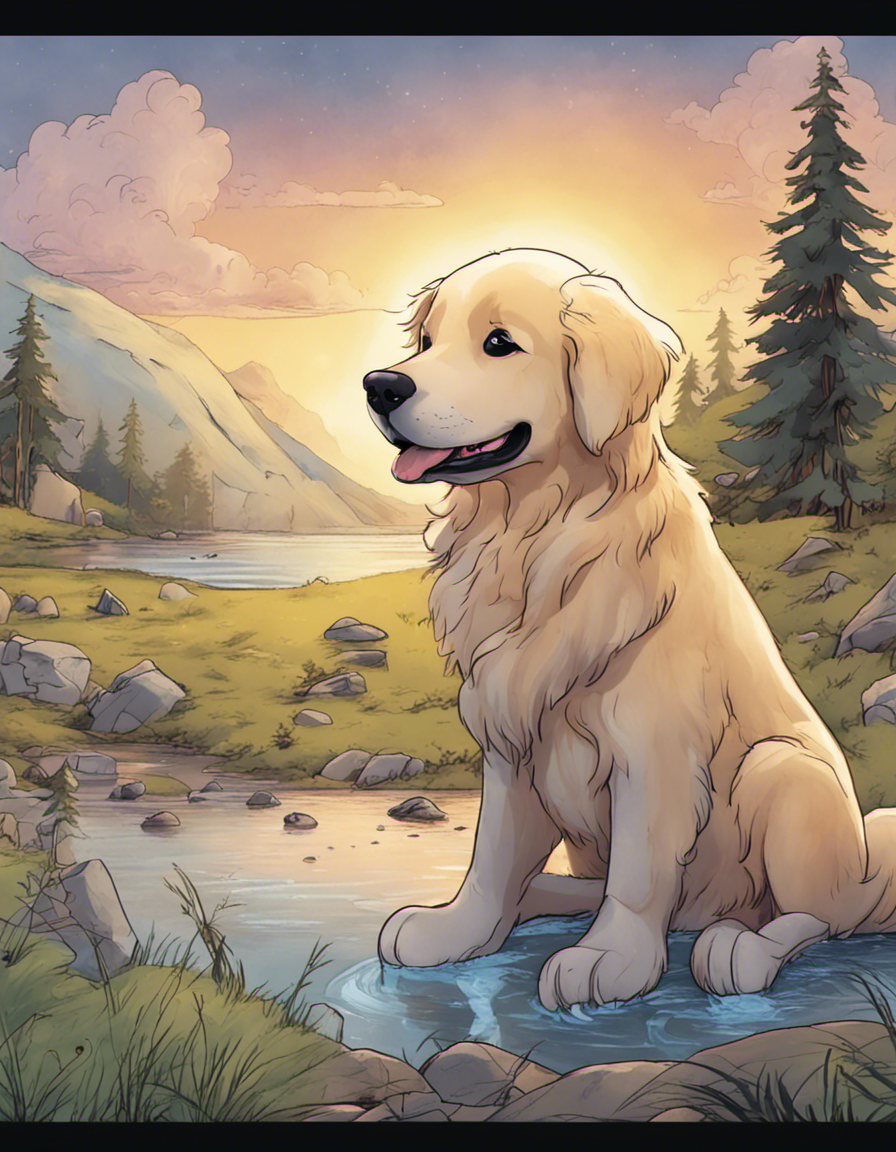

In [8]:
# show the image
from IPython.display import Image
Image(base64.b64decode(output))